In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gzip
import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_predict


In [2]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_test_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')

word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_test_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')

word2vec_selftrain_train_data = pd.read_csv('../Data/TrainingData/word2vec_selftrain_train.csv')
word2vec_selftrain_test_data = pd.read_csv('../Data/ValidateData/word2vec_selftrain_val.csv')

bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_test_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

bert_selftrain_train_data = pd.read_csv('../Data/TrainingData/bert_selftrain_train.csv')
bert_selftrain_test_data = pd.read_csv('../Data/ValidateData/bert_selftrain_val.csv')

In [3]:
def train_lr_model(train_df, test_df, model_path, scaler_path):
  train_data = train_df.copy()
  test_data = test_df.copy()
  
  y_train = train_data.pop('source')  # 假設標籤列名為 'source'
  y_test = test_data.pop('source')  # 假設標籤列名為 'source'

  # 標準化數據
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(train_data.values)
  X_test_scaled = scaler.transform(test_data.values)
  
  # 保存標準化器
  with gzip.open(scaler_path, 'wb') as f:
    joblib.dump(scaler, f)

  # 10折交叉驗證
  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  fold = 0
  confusion_matrices = []
  f2_scores = []
  best_model = None
  best_f2_score = float('-inf')

  for train_index, val_data in kf.split(X_train_scaled):
    fold += 1
    X_train, X_val = X_train_scaled[train_index], X_train_scaled[val_data]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_data]

    model = LogisticRegression(max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train_fold)

    # predict the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    cm_train_result = confusion_matrix(y_train_fold, y_pred_train)
    cm_val_result = confusion_matrix(y_val_fold, y_pred_val)

    confusion_matrices.append((cm_train_result, cm_val_result))

    f2 = fbeta_score(y_val_fold, y_pred_val, beta=2)
    f2_scores.append(f2)

    # 保存最佳模型
    if f2 > best_f2_score:
      best_f2_score = f2
      best_model = model

  # 計算平均F2-score
  avg_f2_score = sum(f2_scores) / len(f2_scores)
  print(f'Average F2 Score: {avg_f2_score:.4f}')

  # 計算混淆矩陣加總再標準化
  sum_cm_train = sum([cm[0] for cm in confusion_matrices])
  sum_cm_val = sum([cm[1] for cm in confusion_matrices])

  norm_cm_train = sum_cm_train.astype('float') / sum_cm_train.sum(axis=1)[:, np.newaxis]
  norm_cm_val = sum_cm_val.astype('float') / sum_cm_val.sum(axis=1)[:, np.newaxis]

  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  fig.suptitle('Normalized Confusion Matrices')

  sns.heatmap(norm_cm_train, annot=True, fmt='.2f', ax=axs[0], cmap='Blues')
  axs[0].set_title('Normalized Train Confusion Matrix')
  axs[0].set_xlabel('Predicted')
  axs[0].set_ylabel('Actual')

  sns.heatmap(norm_cm_val, annot=True, fmt='.2f', ax=axs[1], cmap='Blues')
  axs[1].set_title('Normalized Validation Confusion Matrix')
  axs[1].set_xlabel('Predicted')
  axs[1].set_ylabel('Actual')

  plt.tight_layout()
  plt.subplots_adjust(top=0.88)
  plt.show()

  pickle.dump(best_model, open(model_path, 'wb'))

  # 評估 test set
  y_pred_test = best_model.predict(X_test_scaled)

  test_cm = confusion_matrix(y_test, y_pred_test)
  test_f2_score = fbeta_score(y_test, y_pred_test, beta=2)

  print(f'Test F2 Score: {test_f2_score:.4f}')

  norm_test_cm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize=(7, 5))
  sns.heatmap(norm_test_cm, annot=True, fmt='.2f', cmap='Blues')
  plt.title('Normalized Testing Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()


Average F2 Score: 0.9930


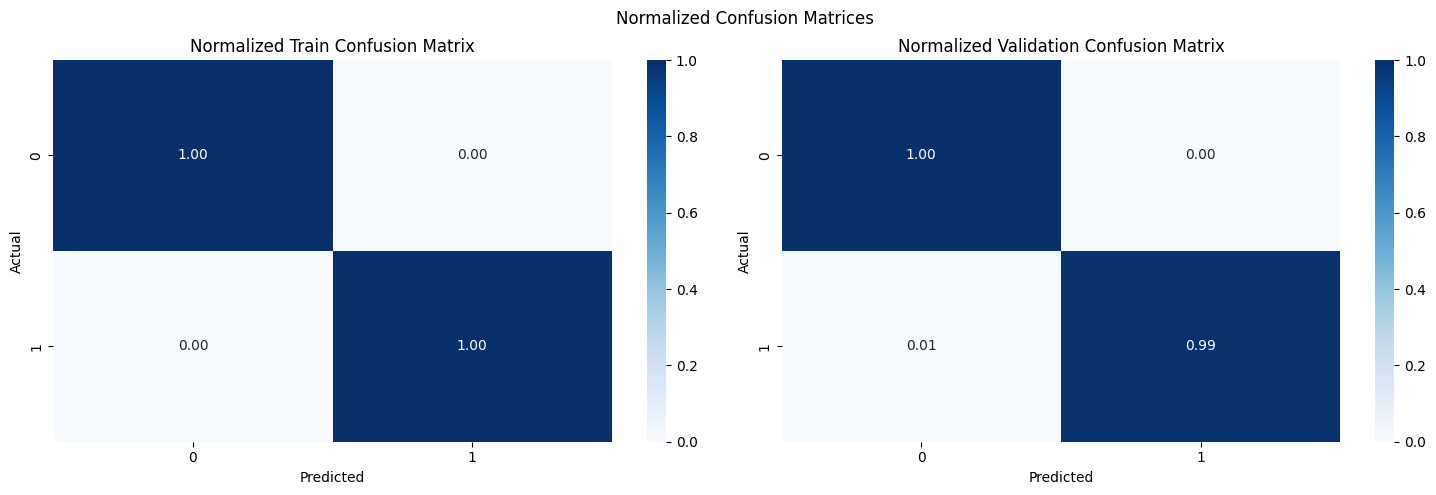

Test F2 Score: 0.9961


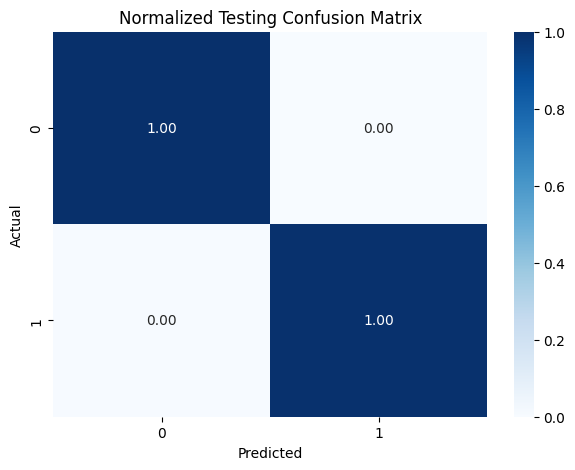

In [4]:
train_lr_model(tfidf_train_data, tfidf_test_data, '../Data/Model/tfidf_lr_10fold_model.pth.gz', '../Data/Model/tfidf_10fold_scaler.pkl.gz')

Average F2 Score: 0.9924


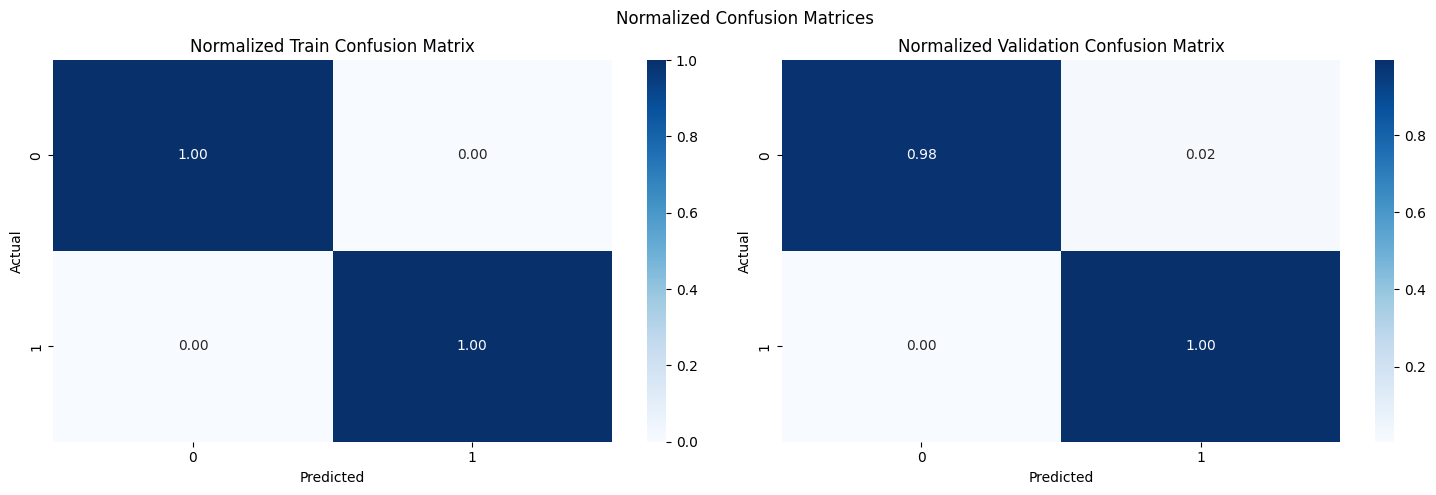

Test F2 Score: 0.9834


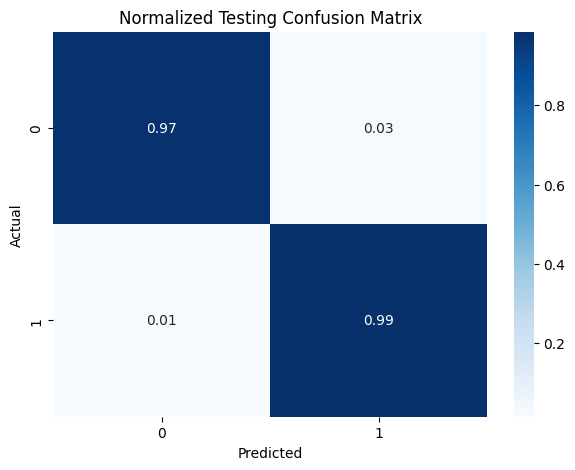

In [5]:
train_lr_model(word2vec_train_data, word2vec_test_data, '../Data/Model/word2vec_lr_10fold_model.pth.gz', '../Data/Model/word2vec_10fold_scaler.pkl.gz')

Average F2 Score: 0.9966


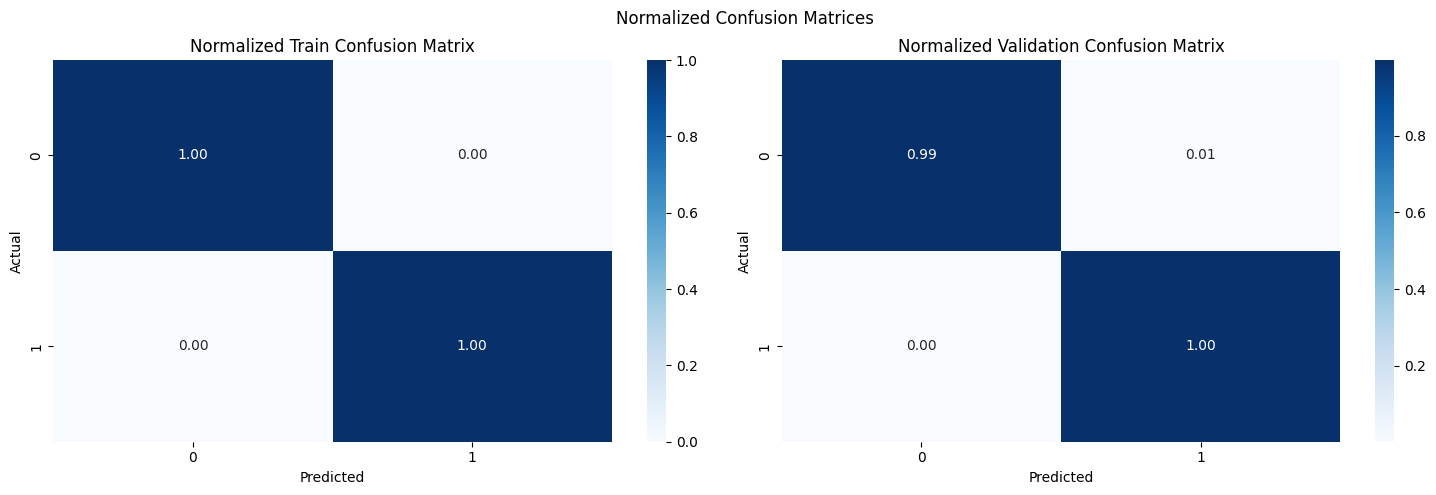

Test F2 Score: 0.9932


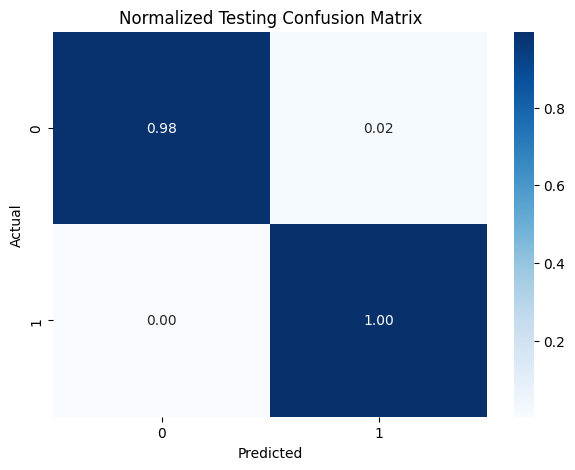

In [6]:
train_lr_model(word2vec_selftrain_train_data, word2vec_selftrain_test_data, '../Data/Model/word2vec_selftrain_lr_10fold_model.pth.gz', '../Data/Model/word2vec_selftrain_10fold_scaler.pkl.gz')

Average F2 Score: 0.9975


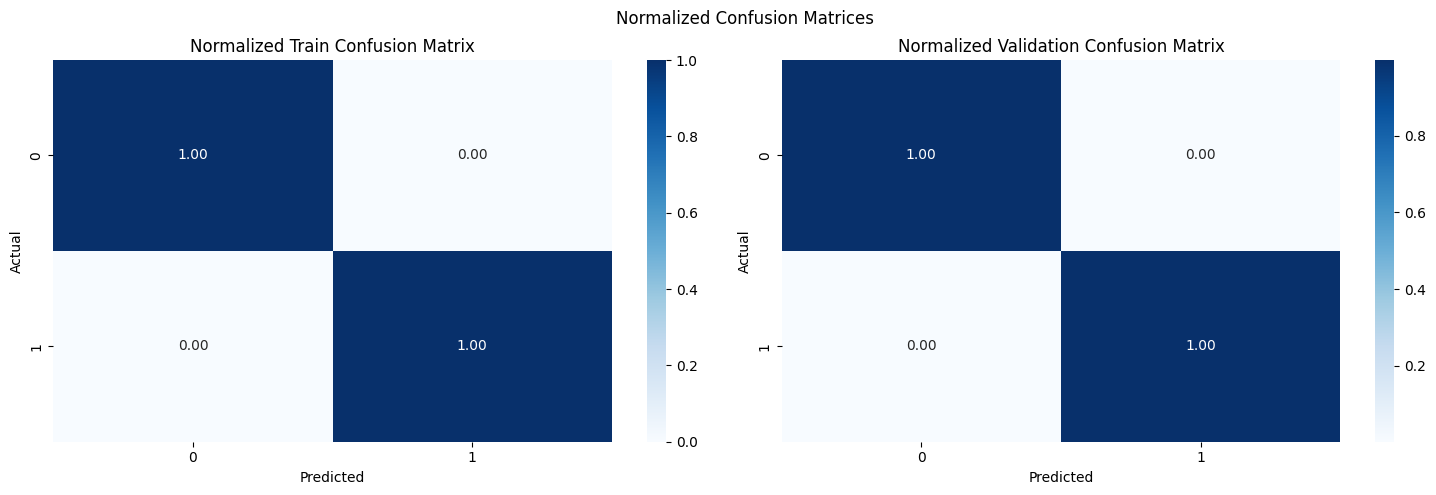

Test F2 Score: 0.9961


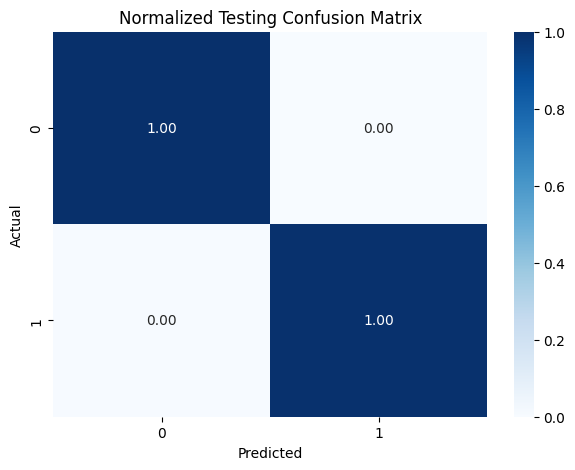

In [7]:
train_lr_model(bert_train_data, bert_test_data, '../Data/Model/bert_lr_10fold_model.pth.gz', '../Data/Model/bert_10fold_scaler.pkl.gz')

Average F2 Score: 0.9975


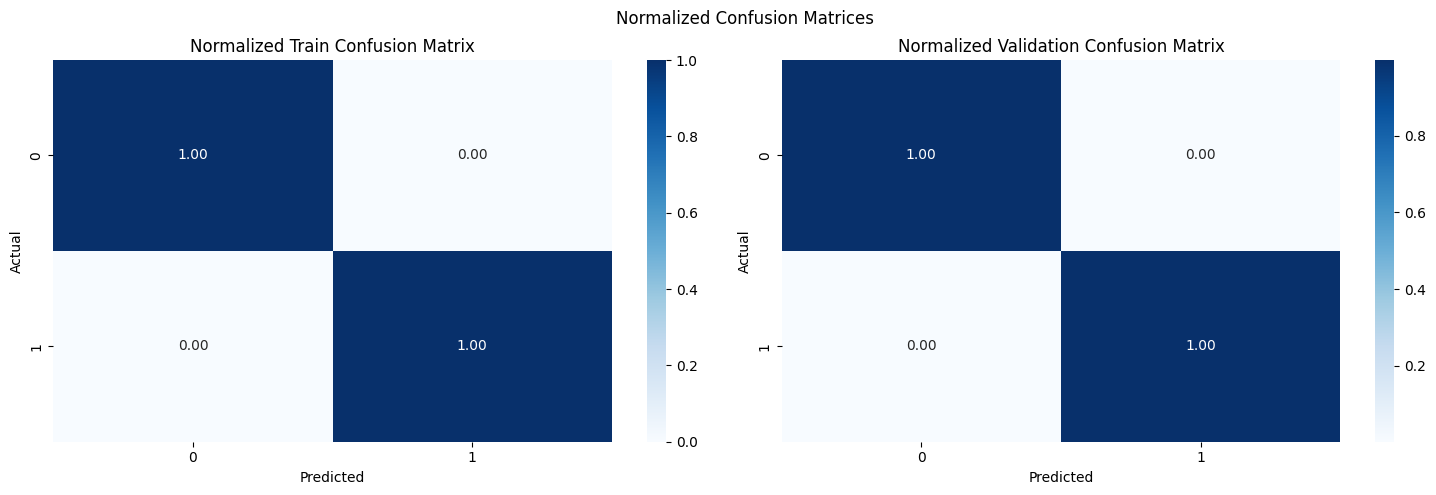

Test F2 Score: 0.9961


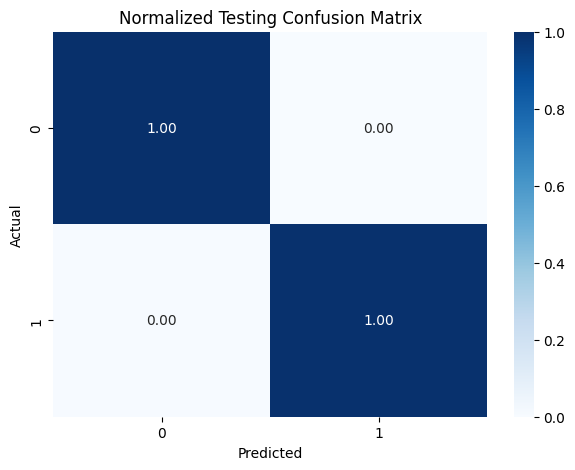

In [8]:
train_lr_model(bert_selftrain_train_data, bert_selftrain_test_data, '../Data/Model/bert_selftrain_lr_10fold_model.pth.gz', '../Data/Model/bert_selftrain_10fold_scaler.pkl.gz')